# Imports

In [2]:
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
from yellowbrick.cluster import KElbow
from mlxtend.frequent_patterns import fpgrowth
import warnings
warnings.filterwarnings(action="ignore")
%load_ext autotime

# Binner Class

In [1]:
class Binner():
    """Turn continuous data into discrete data using KMeans and find patterns in a subset of data above a threshold using FP Growth
    Attributes
    ----------
    models_ : dictionary, (column name -> model)
        Dictionary mapping a column to a KMeans model
    number_of_bins_range_ : tuple, 
        The range of values for number of bins to try, the algorithm will automatically 
        select the best one from the range (default: (2,10)).
    minimal_support_rate_ : float
        A float between 0 and 1 for minimum support of the itemsets returned
    threshold_ : float
        The threshold to use for the conditon: support_rate(full data) * threshold < support_rate(subset)
        
    Notes
    -----
    This class has many helper functions, which can be used out of the box as well. You can create bins for a single column using `create_bins` and 
    find patterns for a dataset using `find_patterns`. The main function is `get_best_subset_patterns`, which finds the best patterns in a subset 
    of data when compared to the full dataset using support rates. The groups for the different binned columns can be accessed from self.models_
    
    Examples
    --------
    >>> import seaborn as sns
    >>> iris = sns.load_dataset('iris')
    >>> titanic = sns.load_dataset('titanic')
    >>> binner = Binner()
    >>> binned_values_iris_petal_length = binner.create_bins('petal_length', iris, number_of_bins_range=(2,10), verbose=True)
    >>> subset_patterns_iris = binner.find_patterns(iris[iris['sepal_length'] > 4.7], minimal_support_rate=.25, number_of_bins_range=(2,10), verbose=True)
    >>> subset_best_patterns_titanic = binner.get_best_subset_patterns(full_df=titanic, subset_df=titanic[titanic['fare'] > 30], 
                                                      minimal_support_rate=.3, threshold=3.8, number_of_bins_range=(2,10))
    """
    
    def __init__(self):
        self.models_ = {}
        self.number_of_bins_range_ = (2,10)
        self.minimal_support_rate_ = .25
        self.threshold_ = 1.0
        
    def sort_model_labels(self, model, original_labels):
        """Sorts labels in ascending order (cluster means) using a fit KMeans model
        After sorting, the higher the label number, the higher the average values of the data with that label
        Parameters
        ----------
        model : a fit KMeans model
        original_labels : the labels we want to sort 
        Returns
        -------
        the sorted labels
        """
        label_idx = np.argsort(model.cluster_centers_.sum(axis=1))
        lookup_table = np.zeros_like(label_idx)
        lookup_table[label_idx] = np.arange(model.n_clusters)
        sorted_labels = lookup_table[original_labels]
        return sorted_labels
        
    def create_bins(self, column_name, df, number_of_bins_range=(2,10), replace_in_df=True, verbose=False):
        """An adaptive binning algorithm to convert a continuous pandas dataframe column to discrete. K means algorithm is used to create bins. 
        Mean sum of squared distances to center is used for evaluation. Knee point detection algorithm is used to select the best number of bins.
        Parameters
        ----------
        column_name : the name of pandas dataframe column to convert
        df : pandas dataframe object
        number_of_bins_range : tuple, optional
            The range of values for number of bins to try, the algorithm will automatically 
            select the best one from the range (default: (2,10)).
        replace_in_df : boolean, optional
            Whether to replace the column in the dataframe with the binned values (default: True).
        verbose : boolean, optional
            Whether to print out info
        Returns
        -------
        the binned values 
        """
        # Assign value to class variable
        self.number_of_bins_range_ = number_of_bins_range
        
        # Format data
        data_to_bin = np.array(df[column_name]).reshape(-1, 1)
        
        # Initialize model
        model = KMeans(random_state=100, n_init=10, n_jobs=-1)
        
        # Fit the model, trying different number of bins (clusters), selecting the best number
        elbow = KElbow(model, k=number_of_bins_range)
        elbow.fit(data_to_bin)
        optimal_number_of_bins = elbow.elbow_value_
        model.set_params(n_clusters=optimal_number_of_bins)
        model.fit(data_to_bin)
        
        # Get the binned value (labels)
        model.labels_ = self.sort_model_labels(model, model.labels_)
        
        # Add model to class variable for all models
        self.models_[column_name] = model
        
        # Replace the numeric column with the discrete values
        if replace_in_df:
            df[column_name] = model.labels_
            
        # Print out message if verbose
        if verbose:
            print("For column: {}, optimal number of bins: {}".format(column_name, optimal_number_of_bins))
            
        # Return discrete values (labels)
        return model.labels_
    
    
    def find_patterns(self, df, minimal_support_rate=.33, number_of_bins_range=(2,10), verbose=False):
        """FP-growth algorithm to find patterns in the dataframe with a minimal support rate, after converting continuous features to discrete
        Parameters
        ----------
        df : pandas dataframe object
        minimal_support_rate : a float between 0 and 1 for minimum support of the itemsets returned
        number_of_bins_range : tuple, optional
            The range of values for number of bins to try, the algorithm will automatically 
            select the best one from the range (default: (2,10)).
        verbose : boolean, optional
            Whether to print out info
        Returns
        -------
        all patterns found above minimal support rate
        """
        # Reinitialize class models
        self.models_ = {}
        
        # Assign value to class variable
        self.minimal_support_rate_ = minimal_support_rate
        
        # Iterate over each column in the dataset
        for column in df.columns:
            
            # Try to see if column is numeric (continuous)
            try:
                data_is_numeric = np.issubdtype(df[column].dtype, np.number)
            except Exception as e:
                print("Warning: cannot create bins for column: {}\n{}\n".format(column, e))
                data_is_numeric = False
                
            # If column is continuous, get discrete values from binning algorithm (KMeans)
            if data_is_numeric:
                try:
                    binned_values = self.create_bins(column, df, number_of_bins_range=number_of_bins_range, verbose=verbose)
                except Exception as e:
                    print("Warning: cannot create bins for column: {}\n{}\n".format(column, e))
                    
        # Convert dataset into all discrete valued columns
        df = pd.get_dummies(df, columns=df.columns)
        
        # Use FP Growth algorithm to find patterns above support rate
        self.patterns = fpgrowth(df, min_support=minimal_support_rate, use_colnames=True)
        
        # Return found patterns
        return self.patterns
    
    def transform_dataset(self, df):
        """Transforms a dataset, converting all continuous features to discrete using the previously fit KMeans models for labels
        Parameters
        ----------
        df : pandas dataframe object to transform
        Returns
        -------
        the transformed dataset
        """
        # Iterate over each column in the dataset
        for column in df.columns:
            
            # If column has been turned into a discrete column already (if there is a saved model for it)
            if column in self.models_:
                
                # Get the model for the column
                model = self.models_[column]
                
                # Get the discrete values using the model on the new data
                predicted_labels = model.predict(np.array(df[column]).reshape(-1,1))
                
                # Sort the labels
                sorted_labels = self.sort_model_labels(model, predicted_labels)
                
                # Change the values to discrete in the dataframe column
                df[column] = sorted_labels
                
        # Convert dataset into all discrete valued columns
        df = pd.get_dummies(df, columns=df.columns)
        return df
    
    def get_pattern_support_rate(self, pattern, df, verbose=False):
        """Gets the support rate for a pattern for a new dataset
        Parameters
        ----------
        pattern : a pattern object
        df : pandas dataframe object
        verbose : boolean, optional
            Whether to print out info
        Returns
        -------
        all patterns found above minimal support rate
        """
        # Get the column names for the pattern items
        pattern_columns = []
        for item in pattern['itemsets']:
            pattern_columns.append(item)
            
        # Calculate the support rate for the full dataset
        total_len = len(df)
        support_num = len(pd.np.where(df[pattern_columns].eq(1).all(1))[0])
        support_rate = support_num/total_len
        
        # Print out message if verbose
        if verbose:
            print("Pattern Items: {}".format(pattern['itemsets']))
            print("Original Pattern Support Rate: {}".format(pattern['support']))
            print("Dataset Pattern Support Rate: {}".format(support_rate))
            
        # Return support rate for full dataset
        return support_rate

    def get_best_subset_patterns(self, full_df, subset_df, minimal_support_rate=.25, threshold=1.0, number_of_bins_range=(2,10), verbose=False):
        """Finds the patterns with the biggest difference between subset data support rate and full data support rate
        Parameters
        ----------
        full_df : pandas dataframe object, full dataset to use for comparison
        subset_df : pandas dataframe object, subset dataset to use for comparison
        minimal_support_rate : float, optional (default: .25)
            a float between 0 and 1 for minimum support of the itemsets returned
        threshold : float, optional (default: 1.0)
            the threshold to use for the conditon: support_rate(full data) * threshold < support_rate(subset)
        number_of_bins_range : tuple, optional (defualt: (2,10))
            The range of values for number of bins to try, the algorithm will automatically 
            select the best one from the range.
        verbose : boolean, optional
            Whether to print out info
        Returns
        -------
        a dataframe with all the patterns that exceed the threshold equation for subset vs full dataset support rate
        """
        # Assign value to class variable
        self.threshold_ = threshold
        
        # Find all patterns above support rate in subset dataframe
        subset_patterns = self.find_patterns(subset_df, minimal_support_rate=minimal_support_rate, number_of_bins_range=number_of_bins_range, verbose=verbose)
        subset_key_patterns = []
        if verbose:
            print("All Susbet Patterns:")
            
        # Iterate over each pattern found
        for idx,pattern in subset_patterns.iterrows():
            
            # Get the full dataset support rate for the pattern
            full_dataset_support_rate = self.get_pattern_support_rate(pattern, self.transform_dataset(full_df.copy()))
            subset_support_rate = pattern['support']
            
            # If above threshold in equation, add pattern to list
            if full_dataset_support_rate * threshold < subset_support_rate:
                pattern_list = [item for item in pattern['itemsets']]
                subset_key_patterns.append({"pattern": pattern_list, "subset_support": subset_support_rate, "full_dataset_support": full_dataset_support_rate})
                if verbose:
                    print(pattern['itemsets'])
                
        # Sort best patterns
        subset_key_patterns = sorted(subset_key_patterns, key=lambda x: x['subset_support'] / x['full_dataset_support'], reverse=True)
        
        # Return dataframe with all pattern information
        return pd.DataFrame(subset_key_patterns)

# Example Usage

In [6]:
import seaborn as sns
iris = sns.load_dataset('iris')
titanic = sns.load_dataset('titanic')
binner = Binner()

time: 19 ms


For column: petal_length, optimal number of bins: 4


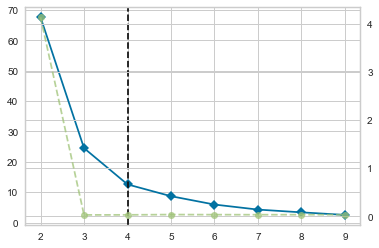

time: 4.84 s


In [7]:
binned_values_iris_petal_length = binner.create_bins('petal_length', iris, number_of_bins_range=(2,10), verbose=True)

For column: sepal_length, optimal number of bins: 4
For column: sepal_width, optimal number of bins: 4
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by check_pairwise_arrays.

For column: petal_width, optimal number of bins: 3


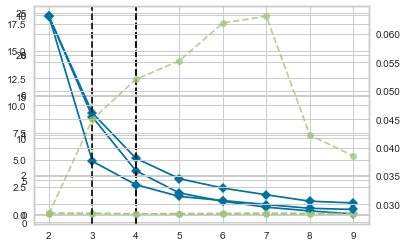

time: 2.3 s


In [8]:
subset_patterns_iris = binner.find_patterns(iris[iris['sepal_length'] > 4.7], minimal_support_rate=.25, number_of_bins_range=(2,10), verbose=True)

Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by check_pairwise_arrays.

Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by check_pairwise_arrays.

Input contains NaN, infinity or a value too large for dtype('float64').

Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by check_pairwise_arrays.

data type not understood

data type not understood



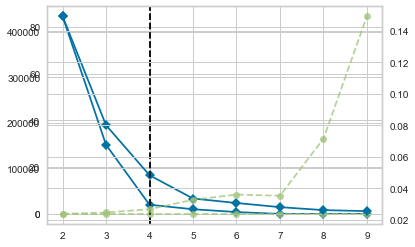

time: 12.5 s


In [9]:
subset_key_patterns_titanic = binner.get_best_subset_patterns(full_df=titanic, subset_df=titanic[titanic['fare'] > 30], 
                                                  minimal_support_rate=.3, threshold=3.8, number_of_bins_range=(2,10))

'<' not supported between instances of 'int' and 'NoneType'

Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by check_pairwise_arrays.



,pattern,subset_support,full_dataset_support
0,[species_setosa],1.00,0.333333
1,[petal_length_0],1.00,0.333333
2,[petal_width_0.2],0.58,0.193333
3,"[species_setosa, petal_length_0]",1.00,0.333333
4,"[petal_width_0.2, petal_length_0]",0.58,0.193333
5,"[petal_width_0.2, species_setosa]",0.58,0.193333
6,"[petal_width_0.2, species_setosa, petal_length_0]",0.58,0.193333
7,"[sepal_width_2, petal_length_0]",0.40,0.133333
8,"[sepal_width_2, species_setosa]",0.40,0.133333
9,"[sepal_width_2, species_setosa, petal_length_0]",0.40,0.133333


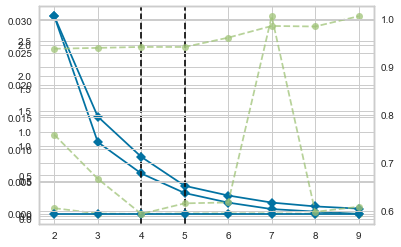

time: 7.7 s


In [10]:
subset_key_patterns = binner.get_best_subset_patterns(full_df=iris, subset_df=iris[iris['species'] == 'setosa'], 
                                                      minimal_support_rate=.25, threshold=1.45, number_of_bins_range=(2,10))
subset_key_patterns

For column: sepal_length, optimal number of bins: 4
For column: sepal_width, optimal number of bins: 4
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by check_pairwise_arrays.

For column: petal_width, optimal number of bins: 3
All Susbet Patterns:
frozenset({'sepal_length_1'})
frozenset({'petal_width_1'})
frozenset({'species_versicolor'})
frozenset({'petal_length_2'})
frozenset({'sepal_length_2'})
frozenset({'petal_width_2'})
frozenset({'species_virginica'})
frozenset({'species_versicolor', 'petal_width_1'})
frozenset({'petal_width_2', 'species_virginica'})


,pattern,subset_support,full_dataset_support
0,"[petal_width_2, species_virginica]",0.330935,0.306667
1,[sepal_length_1],0.309353,0.286667
2,[petal_width_1],0.374101,0.346667
3,[species_versicolor],0.359712,0.333333
4,[petal_length_2],0.323741,0.300000
5,[sepal_length_2],0.345324,0.320000
6,[petal_width_2],0.345324,0.320000
7,[species_virginica],0.359712,0.333333
8,"[species_versicolor, petal_width_1]",0.345324,0.320000


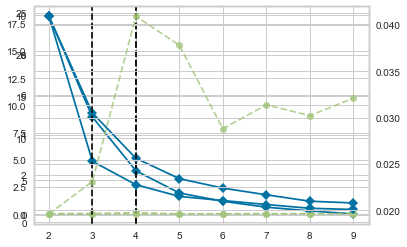

time: 2.44 s


In [11]:
subset_key_patterns = binner.get_best_subset_patterns(full_df=iris, subset_df=iris[iris['sepal_length'] > 4.7], 
                                                      minimal_support_rate=.25, threshold=1.07, number_of_bins_range=(2,10), verbose=True)
subset_key_patterns